# Sentiment Analysis for Indonesian Text - Implemetation Part

This notebook is a source that used for Gemastik 2019 Data Mining.

Created by:

Team: NamaTimnyaApa

Member
- Setyo Nugroho
- Cindy Alifia Putri
- Nurliah Awaliah

University: Telkom Universiy

# BERT Model

Buat Model dan Load weightnya yang sudah di training 

In [ ]:
!pip install tqdm  >> /dev/null
!pip install bert-for-tf2==0.11.6 >> /dev/null

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization import FullTokenizer

from tensorflow import keras
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  df = pd.read_csv("drive/My Drive/dataset/indo_dataset.csv")

  df_train, df_test = train_test_split(df,  test_size=0.3)
  
  return df_train, df_test

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
bert_model_name  = "multi_cased_L-12_H-768_A-12"
bert_ckpt_dir    = os.path.join("drive/My Drive/bert_models/",bert_model_name)
bert_ckpt_file   = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

model_save_location = "drive/My Drive/bert_models/my_sentiment.h5"

In [ ]:
class TwitterSentimentData:
    DATA_COLUMN = "Tweet"
    LABEL_COLUMN = "sentimen"

    def __init__(self, tokenizer: FullTokenizer, sample_size=None, max_seq_len=1024):
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_seq_len = max_seq_len
        train, test = download_and_load_datasets()
        
        train, test = map(lambda df: df.reindex(df[TwitterSentimentData.DATA_COLUMN].str.len().sort_values().index), 
                          [train, test])
                
        if sample_size is not None:
            assert sample_size % 128 == 0
            train, test = train.head(sample_size), test.head(sample_size)
            # train, test = map(lambda df: df.sample(sample_size), [train, test])
        
        ((self.train_x, self.train_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        ((self.train_x, self.train_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[TwitterSentimentData.DATA_COLUMN], row[TwitterSentimentData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)


In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
data = TwitterSentimentData(tokenizer, 
                       sample_size=None,
                       max_seq_len=128)

100%|██████████| 3.83k/3.83k [00:01<00:00, 2.32kit/s]
100%|██████████| 1.64k/1.64k [00:00<00:00, 2.26kit/s]


max seq_len 128


In [ ]:
def create_model(max_seq_len, adapter_size=64):
  """Creates a classification model."""

  #adapter_size = 64  # see - arXiv:1902.00751

  # create the bert layer
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = adapter_size
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  # token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="token_type_ids")
  # output         = bert([input_ids, token_type_ids])
  output         = bert(input_ids)

  print("bert shape", output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=2, activation="softmax")(logits)

  # model = keras.Model(inputs=[input_ids, token_type_ids], outputs=logits)
  # model.build(input_shape=[(None, max_seq_len), (None, max_seq_len)])
  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  # load the pre-trained model weights
  load_stock_weights(bert, bert_ckpt_file)

  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  model.summary()
        
  return model


In [ ]:
model = create_model(data.max_seq_len, adapter_size=None)
model.load_weights(model_save_location)


bert shape (None, 128, 768)
Done loading 196 BERT weights from: drive/My Drive/bert_models/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa38f7e8518> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense

In [ ]:
def predict_model(pred):
  print("> Predicting")
  tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
  pred_tokens    = map(tokenizer.tokenize, pred)
  pred_tokens    = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

  pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
  pred_token_ids = np.array(list(pred_token_ids))

  # print('pred_token_ids', pred_token_ids.shape)

  res = model.predict(pred_token_ids).argmax(axis=-1)
  return res

# Twitter Sentiment Analysis


## Authentication

In [ ]:
!pip install tweepy

In [ ]:
import tweepy
import json


consumer_key= ''
consumer_secret= ''

access_token=''
access_token_secret=''

with open('drive/My Drive/gemastik/twitter.json') as json_file:
  cred = json.load(json_file)
  
  consumer_key= cred['consumer_key']
  consumer_secret= cred['consumer_secret']

  access_token= cred['access_token']
  access_token_secret= cred['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Data Cleaning

Berikut adalah fungsin untuk data cleaning.
Data cleaning meliputi:
1. Decode HTML special character (seperti: `&amp;` yang merupakan simbol &)
2. Hapus @mention
3. Hapus link
4. Hapus keyword RT
5. Decode UTF-8
6. Lowercase
7. Hapus white space
8. Memotong kalimat menjadi 128 karakter


In [ ]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
pat3 = r'RT '
combined_pat = r'|'.join((pat1, pat2, pat3))

def tweet_cleaner(text):
  soup = BeautifulSoup(text, 'lxml')
  souped = soup.get_text()
  stripped = re.sub(combined_pat, '', souped)
  try:
      clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
  except:
      clean = stripped
  letters_only = re.sub("[^a-zA-Z]", " ", clean)
  lower_case = letters_only.lower()
  # During the letters_only process two lines above, it has created unnecessay white spaces,
  # I will tokenize and join together to remove unneccessary white spaces
  words = tok.tokenize(lower_case)
  result = (" ".join(words)).strip()
  return (result[:128]) if len(result) > 128 else result

## Getting Twitter data

Mengambil data dari Twitter dan lakukan cleaning.

Data yang di ambil adalah tweet yang bukan merupakan retweet dan memiliki panjang minimal 50 karakter.

In [ ]:
def get_data(keyword, maxTweets=5):
  print("> Fetching Twitter")
  searchQuery = keyword + " -filter:retweets"
  public_tweets = []
  sinceId = None

  tweetsPerQry = 100
  max_id = -1
  result = []
  tweetCount = 0
  while tweetCount < maxTweets:
    try:
      if (max_id <= 0):
        if (not sinceId):
            new_tweets = api.search(q=searchQuery, tweet_mode="extended", count=tweetsPerQry)
        else:
            new_tweets = api.search(q=searchQuery, tweet_mode="extended", count=tweetsPerQry,
                                    since_id=sinceId)
      else:
        if (not sinceId):
            new_tweets = api.search(q=searchQuery, tweet_mode="extended", count=tweetsPerQry,
                                    max_id=str(max_id - 1))
        else:
            new_tweets = api.search(q=searchQuery, tweet_mode="extended", count=tweetsPerQry,
                                    max_id=str(max_id - 1),
                                    since_id=sinceId)
      if not new_tweets:
        print("No more tweets found")
        break
      
      print("> Tweet fetched")
      print("  Got " + str(len(new_tweets)) + " From API")
      cleaned_tweets = []
      for t in new_tweets:
        cleaned = tweet_cleaner(t.full_text)
        if (len(cleaned) > 10):
          cleaned_tweets.append(cleaned)
      result += cleaned_tweets
      print("  Got " + str(len(cleaned_tweets)) + " Cleaned Tweet")

      tweetCount = len(result)
      print("  Current tweet count: " + str(tweetCount))
      
      max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break
        
  return result[:maxTweets]

## Visualize

Visualisasi data prediksi

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker

def visualize(title, tweets, predict_result):
  result = []
  for text, sentiment in zip(tweets, predict_result):
    result.append([text,  ["Negatif","Positif"][sentiment]])
    print(" text:", text)
    print("   hasil:", ["Negatif","Positif"][sentiment])
  # Visualize
  df = pd.DataFrame(result, columns=["text", "sentiment"])
  sns.set(style="whitegrid")
  ax = sns.countplot(x="sentiment", data=df, order=["Negatif", "Positif"])
  ax.set_title(title)
  ax.set_ylabel("")
  ax.set_xlabel("Sentiment")
  
  ncount = len(df)
    
  # Make twin axis
  ax2=ax.twinx()

  # Switch so count axis is on right, frequency on left
  ax2.yaxis.tick_left()
  ax.yaxis.tick_right()

  # Also switch the labels over
  ax.yaxis.set_label_position('right')
  ax2.yaxis.set_label_position('left')

  ax2.set_ylabel('Frequency [%]')

  for p in ax.patches:
      x=p.get_bbox().get_points()[:,0]
      y=p.get_bbox().get_points()[1,1]
      ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
              ha='center', va='bottom') # set the alignment of the text

  # Use a LinearLocator to ensure the correct number of ticks
  ax.yaxis.set_major_locator(ticker.LinearLocator(11))

  # Fix the frequency range to 0-100
  ax2.set_ylim(0,100)
  ax.set_ylim(0,ncount)

  # And use a MultipleLocator to ensure a tick spacing of 10
  ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))


  # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
  ax2.grid(None)


# Analysis

## Pindah Ibukota dari Twitter

In [ ]:
tweets = get_data("Pindah Ibukota", 500)
predictions = predict_model(tweets)

> Fetching Twitter
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 100
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 200
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 300
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 400
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 500
> Predicting


 text: didu maksa amat pindah ibukota
   hasil: Negatif
 text: sy sdh tau dari awal klo pindah ibukota bkl butuh danah bsar knp g di gunakan tuk mengirangi ini sj jd negara g di jdikan boneka
   hasil: Negatif
 text: ingin segera cepat ibukota pindah ke kalimantan biar kalu mau demo harus mikir dlu karna nyebrang pulau
   hasil: Negatif
 text: aku malah dr kmrn mikirnya gini pas ada wacana ibukota pindah ke kalimantan itu yg aku takutin cuman kan kalimantan hutannya lua
   hasil: Negatif
 text: kalau bgtu model mahasiswa disumbar kalimantan lebih baik gak usah pindah ibukota bapak presiden terlalu mereka itu sayabersamaj
   hasil: Negatif
 text: untung ibukota negara segera pindah
   hasil: Negatif
 text: buruan pindah deh ibukota ke kalimantan kata anis ow pantes pak de ngotot bgt pengen pindah biar gak didemo jd mahasiwa kudu ngo
   hasil: Negatif
 text: kecuali gua pegawai kemenkumham gua akan bersuara tapi ibukota ttp pindah yaa
   hasil: Negatif
 text: segitu parahkah jakarta sehi

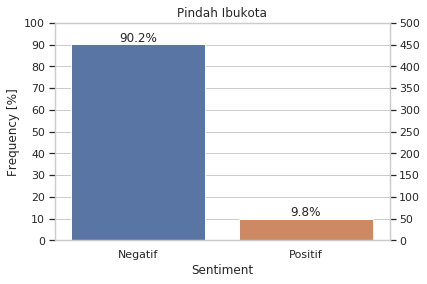

In [ ]:
visualize("Pindah Ibukota", tweets, predictions)

## RUU KPK dari Twitter

In [ ]:
tweets = get_data("RUU KPK", 500)
predictions = predict_model(tweets)

> Fetching Twitter
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 100
> Tweet fetched
  Got 100 From API
  Got 99 Cleaned Tweet
  Current tweet count: 199


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Sic4mRqbgW" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


> Tweet fetched
  Got 100 From API
  Got 99 Cleaned Tweet
  Current tweet count: 298


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/aBqmNlT1UA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 398
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 498
> Tweet fetched
  Got 100 From API
  Got 100 Cleaned Tweet
  Current tweet count: 598
> Predicting


 text: bentrokan antara mahasiswa yang melakukan aksi menolak ruu kuhp dan pengesahan uu kpk dengan polisi membuat kawasan senayan jaka
   hasil: Negatif
 text: revocar la ley de kpk y la ley de recurcos naturales pembatalan uu kpk dan uu sda aprobar la ley de violencia sexual y la ley de
   hasil: Positif
 text: ruu kpk sudh disahkan dan ruu khup sudh ditunda oleh presiden terus mahasiswa yang turun kejalan dalam rangka apa jika kalian ka
   hasil: Positif
 text: bpjs naik subsidi listrik dikurangi kpk dilemahkan rkuhp dan ruu lain dianggap aneh ibukota pindah ngabisin uang dll gak milih o
   hasil: Negatif
 text: zery tapi satu hal lagi ketika semua org menghina bang mereka lupa siapa yang mengesahkan ruu kpk tersebut d
   hasil: Negatif
 text: dapet pesen dari mami lewat telfon kamu boleh ikut demo ikut protes kalo kamu udah baca udah paham semua isi ruu kuhp dan ruu kp
   hasil: Negatif
 text: senator abdul aziz tolak ruu kpk
   hasil: Positif
 text: kriting klo soal ruu udh ditund

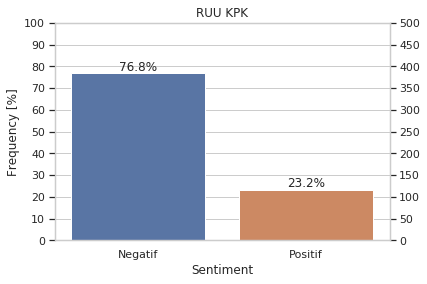

In [ ]:
visualize("RUU KPK", tweets, predictions)

## RUU KUHP dari Twitter

In [ ]:
tweets = get_data("RUU KUHP", 500)
predictions = predict_model(tweets)

> Fetching Twitter
> Tweet fetched
  Got 99 From API
  Got 99 Cleaned Tweet
  Current tweet count: 99
> Tweet fetched
  Got 98 From API
  Got 97 Cleaned Tweet
  Current tweet count: 196
> Tweet fetched
  Got 99 From API
  Got 96 Cleaned Tweet
  Current tweet count: 292


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/OxpzFLmGsH" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


> Tweet fetched
  Got 100 From API
  Got 99 Cleaned Tweet
  Current tweet count: 391
> Tweet fetched
  Got 100 From API
  Got 99 Cleaned Tweet
  Current tweet count: 490
> Tweet fetched
  Got 100 From API
  Got 99 Cleaned Tweet
  Current tweet count: 589
> Predicting


 text: para pelajar tersebut mengatakan tuntutannya agar ruu kuhp tidak perlu dilakukan oleh anggota dpr emak emak cari anaknya yang de
   hasil: Negatif
 text: agar apa ruu kuhp di sahkan agar indonesia makin lemah di mata negara lain entah apa yang merasuki dpr mensahkan ruu itu faedahn
   hasil: Negatif
 text: tetep aja kalo ngata ngatain dpr kena juga mamah wkwkwkwk harusnya orang orang yang bikin ruu kuhp goblog biar ga durhaka wkwkwk
   hasil: Negatif
 text: dulu rebutan sekarang
   hasil: Negatif
 text: hotman paris sebut ruu kuhp aneh
   hasil: Negatif
 text: cek polisi terluka saat amankan demo mahasiswa tolak ruu kuhp mereka luka karena
   hasil: Negatif
 text: cek polisi terluka saat amankan demo mahasiswa tolak ruu kuhp mereka luka karena
   hasil: Negatif
 text: terpilihlah wacana ruu kuhp dkk itu hasile rakyate panik akhirnya ketidakstabilan negara terjadi akibatnya saham turun rupiah ju
   hasil: Negatif
 text: koko yazid di tv dan media pers lainnya mahasiswa lantang me

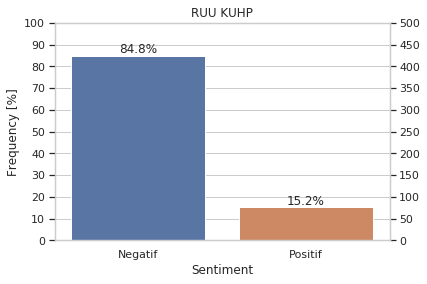

In [ ]:
visualize("RUU KUHP", tweets, predictions)

## Berita CNN

In [ ]:
news = pd.read_csv("drive/My Drive/dataset/DatasetCNN.txt", sep="\t", header=None)[0].tolist()
news = list(map(tweet_cleaner, news))
print("News Count: ", len(news))
predictions = predict_model(news)

News Count:  7
> Predicting


 text: karena profesional dan integritasnya kurang tentunya harus diawasi tanggung jawab dewan pengawas adalah presiden jgn khawatir ap
   hasil: Negatif
 text: dewan pengawas jelas jadi kuping para koruptor info penyadapan kemungkinan besar bakal bocor duluan wani piro
   hasil: Negatif
 text: tercium aroma mega korupsi mendatang
   hasil: Positif
 text: rakyat mana yg tahu ttg kpk rakyat nya icw sj yg bingung sbb akan kehilangan sumber makan
   hasil: Negatif
 text: kpk itu apa setiap mau ada penataan selalu ribut bubarkan sj kpk
   hasil: Positif
 text: bukan pelemahan kpk lebih tepat ya penguasaan kpk untuk kepentingan yang menguasai melalui kewenangan dewas kpkjadimesinpenghanc
   hasil: Negatif
 text: rakyat juga lebih dari segudang curiga kepada kpk yg sdh nyata dan terlihat bermain politik tetaprevisiuudkpk
   hasil: Positif


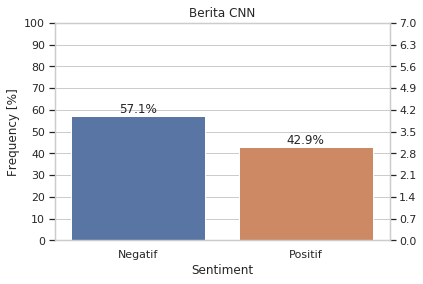

In [ ]:
visualize("Berita CNN", news, predictions)

## Berita Kompas

In [ ]:
news = pd.read_csv("drive/My Drive/dataset/kompas.txt", sep="\t", header=None)[0].tolist()
news = list(map(tweet_cleaner, news))
print("News Count: ", len(news))
predictions = predict_model(news)

News Count:  51
> Predicting


 text: sarang penyamun
   hasil: Negatif
 text: mana berani kan mereka juga
   hasil: Negatif
 text: yg jd pertanyaan knpa ya usulan dpr slma ini seringkali tdk sesuai khendak rakyat pdhal dpr itu dewan perwakilan rakyat apakah a
   hasil: Negatif
 text: sebagai insan berpendidikan mahasiswa tentu boleh berunjuk rasa demi mengemukakan aspirasi dan suara namun harus tetap dalam kor
   hasil: Negatif
 text: kapan dpr ri mengesahkan ruu hukuman mati buat koruptor
   hasil: Negatif
 text: akhir nya masyarakat mengetahui bahwa jokowi dan politisi hitam sangat berkepentingan untuk melemahkan kpk
   hasil: Positif
 text: yg jd pertanyaan knpa ya usulan dpr slma ini seringkali tdk sesuai khendak rakyat pdhal dpr itu dewan perwakilan rakyat apakah a
   hasil: Negatif
 text: alhamdulillah pengesahan uu kpk telah ketok palu semoga kpk dgn pimpinan baru dgn sistem yg baru akan membuat jalan nya kpk tdk 
   hasil: Positif
 text: jgn campur adukan pembenahan kpk dengan isue dan taliban itu tdk perlu

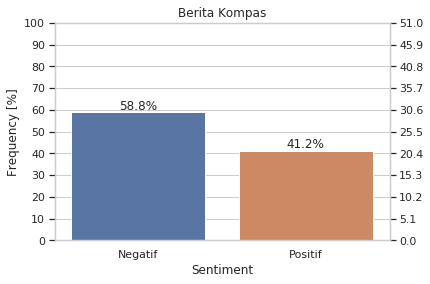

In [ ]:
visualize("Berita Kompas", news, predictions)

## Berita Mata Najwa

In [ ]:
news = pd.read_csv("drive/My Drive/dataset/MataNajwa.txt", sep="\t", header=None)[0].tolist()
news = list(map(tweet_cleaner, news))
print("News Count: ", len(news))
predictions = predict_model(news)

News Count:  170
> Predicting


 text: beranikah dpr ri merancang undang hukuman mati buat koruptor
   hasil: Negatif
 text: isky raditya sama saja bunuh diri koruptornya kan dpr ri
   hasil: Negatif
 text: tambah pasal hukuman mati di uu yang sudah direvisi itu sebenarnya beresiko sebab sama saja itu minta ijin ke dewan pengawas ben
   hasil: Negatif
 text: bila kami merancangnya apa guna selama ini kami mengincar milyaran anggaran untuk kami kantongi kami juga perlu itu untuk menutu
   hasil: Positif
 text: apakah anda pernah berfikir untuk meracuni kolam yg telah anda memelihara ikan nya dari kecil
   hasil: Negatif
 text: ngga hukumny aja sekarang direvisi sama mereka koruptor bisa bebas bersyarat haha
   hasil: Negatif
 text: uu bunuh diri hhahahahahahahahahahah
   hasil: Positif
 text: mungkin terjadi koruptor di hukum mati jika pimpanan baru nanti di pileh
   hasil: Negatif
 text: haha wong yg kebanyakan koruptornya dari dpr sendiri mana mgkn mereka mau gali kubur mereka sendiri
   hasil: Negatif
 text: gk aka

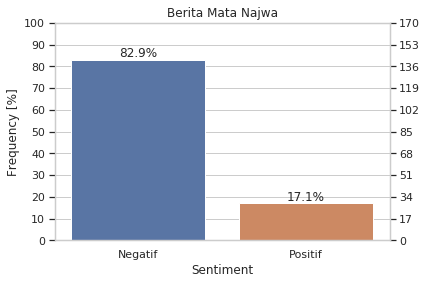

In [ ]:
visualize("Berita Mata Najwa", news, predictions)